# Boosting

In this notebook, I will implement a simple Boosting ensemble. We will work through the Boston House Prices regression dataset. 

In [7]:
## imports ##
import numpy as np
import pandas as pd
from typing import Dict, Any, List
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,make_scorer

We can now create the class that will encapsulate the boosting algorithm:

In [197]:
## boosting regressor ##
class BoostingRegressor(object):
    #initializer
    def __init__(self, weak_learner : Any, n_elements : int = 100, learning_rate : float = 0.01) -> None:
        self.weak_learner  = weak_learner
        self.n_elements    = n_elements
        self.learning_rate = learning_rate
        self.f             = []
        self.residuals     = []
        
    #destructor
    def __del__(self) -> None:
        del self.weak_learner
        del self.n_elements
        del self.learning_rate
        del self.f
        del self.residuals
    
    #public function to return model parameters
    def get_params(self, deep : bool = False) -> Dict:
        return {'weak_learner':self.weak_learner,'n_elements':self.n_elements,'learning_rate':self.learning_rate}
    
    #public function to train the ensemble
    def fit(self, X_train : np.array, y_train : np.array) -> None:
        #initialize residuals
        r = np.copy(y_train).astype(float)
        #loop through the specified number of iterations in the ensemble
        for _ in range(self.n_elements):
            #make a copy of the weak learner
            model = clone(self.weak_learner)
            #fit the weak learner on the current dataset
            model.fit(X_train,r)
            #update the residuals
            r -= self.learning_rate*model.predict(X_train)
            #append resulting model
            self.f.append(model)
            #append current mean residual
            self.residuals.append(np.mean(r))    
            
    #public function to return residuals
    def get_residuals(self) -> List:
        return(self.residuals)
    
    #public function to generate predictions
    def predict(self, X_test : np.array) -> np.array:
        #initialize output
        y_pred = np.zeros((X_test.shape[0]))
        #traverse ensemble to generate predictions
        for model in self.f:
            y_pred += self.learning_rate*model.predict(X_test)
        #return predictions
        return(y_pred)

## Boosting Regression

### Load Regression Dataset

Here I'll load the boston house prices dataset. Note I already analysed these data in Article VI - Random Forest.

In [193]:
## load classification dataset ##
data = load_boston()
X    = data.data
y    = data.target

### Investigate Residuals

In this section I want to check that the residuals converge. I will also setup the weak learner, which in our case will be a regression decision stump:

In [194]:
## initialize a weak learner ##
weak_m = DecisionTreeRegressor(max_depth=1)

In [195]:
## set the learning rates to try ##
learning_rates = [0.1,0.01,0.001,0.0001]

In [198]:
## loop through the learning rates, record residuals ##
dfRes = pd.DataFrame()
for lr in learning_rates:

    #declare a boosting regressor
    rgr = BoostingRegressor(weak_learner=weak_m, n_elements=1000, learning_rate=lr)
    
    #fit the model
    rgr.fit(X,y)
    
    #record residuals
    dfRes[str(lr)] = rgr.get_residuals()

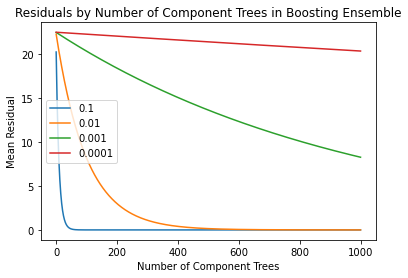

In [199]:
## plot the residuals ##
dfRes.plot()
plt.title('Residuals by Number of Component Trees in Boosting Ensemble')
plt.xlabel('Number of Component Trees')
plt.ylabel('Mean Residual')
plt.show()

We can see the residuals converge towards 0 as we progress through the ensemble. This convergence is faster for larger learning rates.

### Investigate Performance

Here I will use 10-fold cross-validation to measure the performance of the boosting regressor:

In [200]:
## define the scoring metrics ##
scoring_metrics = {'mae': make_scorer(mean_absolute_error), 
                   'mse': make_scorer(mean_squared_error),
                   'r2': make_scorer(r2_score)}

In [201]:
## loop through each learning rate & evaluate for n_elements=1000 ##
for lr in learning_rates:
    #define the model
    rgr = BoostingRegressor(weak_learner=weak_m, n_elements=1000, learning_rate=lr)
    #cross validate
    dcScores = cross_validate(rgr,X,y,cv=10,scoring=scoring_metrics)
    #report results
    print('Learning Rate: ',lr)
    print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
    print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
    print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))
    print('')

Learning Rate:  0.1
Mean MAE: 3.02
Mean MSE: 20.08
Mean R2: 0.48

Learning Rate:  0.01
Mean MAE: 3.16
Mean MSE: 21.63
Mean R2: 0.52

Learning Rate:  0.001
Mean MAE: 8.75
Mean MSE: 116.08
Mean R2: -1.79

Learning Rate:  0.0001
Mean MAE: 20.31
Mean MSE: 491.88
Mean R2: -14.08



In [91]:
## loop through each learning rate & evaluate for n_elements=10000 ##
for lr in learning_rates:
    #define the model
    rgr = BoostingRegressor(weak_learner=weak_m, n_elements=10000, learning_rate=lr)
    #cross validate
    dcScores = cross_validate(rgr,X,y,cv=10,scoring=scoring_metrics)
    #report results
    print('Learning Rate: ',lr)
    print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
    print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
    print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))
    print('')

Learning Rate:  0.1
Mean MAE: 3.30
Mean MSE: 23.75
Mean R2: 0.34

Learning Rate:  0.01
Mean MAE: 3.03
Mean MSE: 20.26
Mean R2: 0.48

Learning Rate:  0.001
Mean MAE: 3.15
Mean MSE: 21.63
Mean R2: 0.52

Learning Rate:  0.0001
Mean MAE: 8.75
Mean MSE: 116.15
Mean R2: -1.79



Finally, let's compare these results to those we can obtain by using just the decision tree stump:

In [90]:
#cross validate
dcScores = cross_validate(weak_m,X,y,cv=10,scoring=scoring_metrics)
#report results
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))

Mean MAE: 6.34
Mean MSE: 70.54
Mean R2: -0.85


Model | Learning Rate | Number of Elements | MAE | MSE | R2
--- | --- | --- | --- | --- | ---
Boosting Regressor | 0.1 | 1000 | 3.02 | 20.08 | 0.48
Boosting Regressor | 0.01 | 1000 | 3.16 | 21.63 | 0.52
Boosting Regressor | 0.001 | 1000 | 8.75 | 116.08 | -1.79
Boosting Regressor | 0.0001 | 1000 | 20.31 | 491.88 | -14.08
Boosting Regressor | 0.1 | 10000 | 3.30 | 23.75 | 0.34
Boosting Regressor | 0.01 | 10000 | 3.03 | 20.26 | 0.48
Boosting Regressor | 0.001 | 10000 | 3.15 | 21.63 | 0.52
Boosting Regressor | 0.0001 | 10000 | 8.75 | 116.15 | -1.79
Decision Tree Stump | NA | NA | 6.34 | 70.54 | -0.85
Scikit-Learn Random Forest | NA | NA | 3.01 | 20.10 | 0.55

The optimal boosting regressor tested is the one with the largest learning rate (0.1) and smallest number of elements (1000). The performance of this specific model is similar to that seen with the scikit-learn random forest regressor (See article on Random Forest). Notice the individual decision tree stump is also included in this comparision. The choice of learning rate and number of elements in the ensemble is very important, and it is apparent these parameters need to be balanced off each other.